In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

import sys
sys.path.append("../pytorch-scarf")

from scarf.loss import NTXent
from scarf.model import SCARF
from scarf.dataset import SCARFDataset

from tqdm import tqdm
import numpy as np

from example.utils import get_device, dataset_embeddings, fix_seed, train_epoch

seed = 1234
fix_seed(seed)

from utils.data_utils import load_data_cross_validation, load_data_train_test, get_random_noisy_row, load_creditcardfraud, load_uci

In [2]:
## Fedonce import
 
from model.models import FC, AggModel, CNN, ResNet18, SmallCNN, BareSmallCNN, NCF, AggModelTest
from utils.utils import generate_random_targets, calc_optimal_target_permutation, \
    is_perturbation
from utils.data_utils import LocalDataset, AggDataset, ImageDataset


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import transforms

# Data

In [13]:
xs_train_val, y_train_val, xs_test, y_test = load_uci(test_rate = 0.2)

Dataset size before:	30000
Dataset size after:	29601


## Scarf

In [5]:

x_train_val = np.concatenate(xs_train_val, axis=1)
x_test = np.concatenate(xs_test, axis=1)

# to torch dataset
train_ds = SCARFDataset(x_train_val, y_train_val)
test_ds = SCARFDataset(x_test, y_test)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")

Train set: (23680, 25)
Test set: (5921, 25)


### Training

Text(0, 0.5, 'loss')

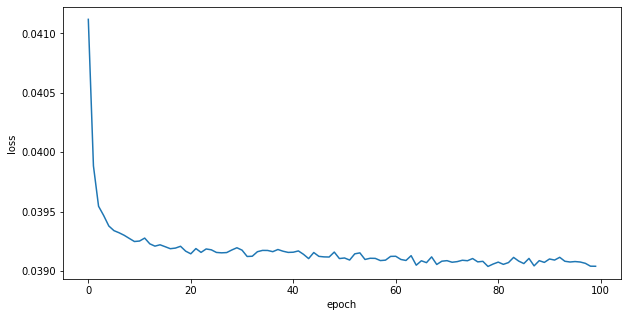

In [14]:
batch_size = 128
epochs = 100
device = get_device()

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=10,
    num_hidden_encoder=3,
    dim_hidden_head=50,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}", end="\r")


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [15]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

(23680, 10)
(5921, 10)


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4600
           1       0.70      0.25      0.37      1321

    accuracy                           0.81      5921
   macro avg       0.76      0.61      0.63      5921
weighted avg       0.79      0.81      0.77      5921



/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


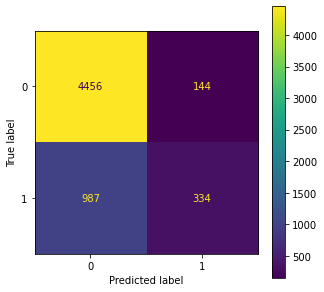

In [9]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(x_train_val, y_train_val)
vanilla_predictions = clf.predict(x_test)

print(classification_report(y_test, vanilla_predictions))
cm = confusion_matrix(y_test, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4600
           1       0.00      0.00      0.00      1321

    accuracy                           0.78      5921
   macro avg       0.39      0.50      0.44      5921
weighted avg       0.60      0.78      0.68      5921



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


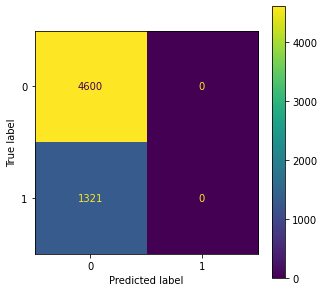

In [16]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, y_train_val)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(y_test, vanilla_predictions))
cm = confusion_matrix(y_test, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# NAT

In [75]:
local_batch_size=100
num_workers = 0
local_hidden_layers = [50, 30]
num_features = X.shape[1]
local_output_dim = 10
local_lr = 3e-4
local_weight_decay=1e-5


In [76]:
X = np.concatenate(xs_train_val, axis=1)
X_test = np.concatenate(xs_test, axis=1)
num_instances = X.shape[0]
y = generate_random_targets(num_instances, local_output_dim)[None, :, :]

In [77]:
X.shape

(23680, 25)

In [78]:
y.shape

(1, 23680, 10)

In [89]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y[0]).float()  # y will be updated
dataset = LocalDataset(X_tensor, y_tensor)

In [90]:
data_loader = DataLoader(dataset, batch_size=local_batch_size, shuffle=True,
                                 drop_last=True, num_workers=num_workers,
                                 multiprocessing_context='fork' if num_workers > 0 else None)


In [91]:
model = FC(num_features, local_hidden_layers, output_size=local_output_dim,
                                         activation='tanh') 

In [92]:
def mse_loss(x, y):
    return torch.mean(torch.sum((x - y) ** 2, dim=1))

In [93]:
model = model.to(device)
model = nn.DataParallel(model)

loss_fn = mse_loss

In [94]:
optimizer = optim.Adam(model.parameters(), lr=local_lr, weight_decay=local_weight_decay)


In [98]:
total_loss = 0.0
num_mini_batches = 0
num_local_rounds = 100
update_target_freq = 1
for i in tqdm(range(num_local_rounds)):
    update_targets = ((i + 1) % update_target_freq == 0)
    for j, (idx, X_i, y_i) in enumerate(data_loader, 0):
        X_i = X_i.to(device)
        y_i = y_i.to(device)

        optimizer.zero_grad()

        y_pred = model(X_i)
        if update_targets:
            output = y_pred.cpu().detach().numpy()
            new_targets = calc_optimal_target_permutation(output, y_i.cpu().detach().numpy())
            new_targets_tensor = torch.from_numpy(new_targets)
            dataset.update_targets(idx, new_targets_tensor)
            y_i = torch.from_numpy(new_targets).to(device)

        loss = loss_fn(y_pred, y_i)

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        num_mini_batches += 1

    total_loss = 0.0
    num_mini_batches = 0


100%|█████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


In [102]:
def predict_local(X, model, batch_size=256):
    X_tensor = torch.from_numpy(X).float()
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers = num_workers)

    Z_list = []
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        for (X_i,) in dataloader:
            X_i = X_i.to(device)
            Z_i = model(X_i)
            Z_list.append(Z_i)
    Z = torch.cat(Z_list).detach().cpu().numpy()
    return Z

In [107]:
xs_train_val, y_train_val, xs_test, y_test = load_uci(test_rate = 0.2)

Dataset size before:	30000
Dataset size after:	29601


In [108]:
X = np.concatenate(xs_train_val, axis=1)
X_test = np.concatenate(xs_test, axis=1)

In [109]:
# get embeddings for training and test set
train_embeddings = predict_local(X, model)
test_embeddings = predict_local(X_test, model)


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4600
           1       0.70      0.25      0.37      1321

    accuracy                           0.81      5921
   macro avg       0.76      0.61      0.63      5921
weighted avg       0.79      0.81      0.77      5921



/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


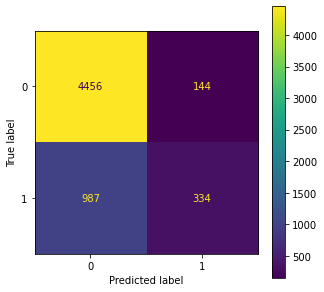

In [112]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(X, y_train_val)
vanilla_predictions = clf.predict(X_test)

print(classification_report(y_test, vanilla_predictions))
cm = confusion_matrix(y_test, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4600
           1       0.64      0.13      0.22      1321

    accuracy                           0.79      5921
   macro avg       0.72      0.55      0.55      5921
weighted avg       0.76      0.79      0.73      5921



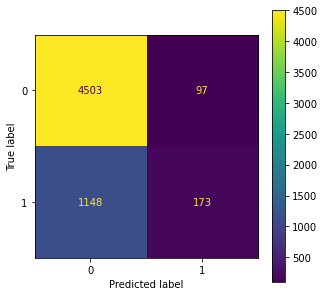

In [117]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, y_train_val)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(y_test, vanilla_predictions))
cm = confusion_matrix(y_test, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)